## PoNQ: a Neural QEM-based Mesh Representation

https://arxiv.org/pdf/2403.12870

This notebook is an overview of the PoNQ framework. More specifically the goal is to understand the theory behind it and run a task for converting point cloud into a mesh representation.

**Problem:** Lack of learnable 3D representations *that can capture ridges and corners*, while guaranteeing valid output meshes representing real 3D shapes.

**Other work**: Initially shape representation for learning relied on implicit volumetric representations. Training was costly (due to requirements of processing the whole volume). Resulting mesh surfaces lacked volume, were overly smoothed shapes, even where sharp efeatures were expected (lack of sharpness).

Other methods don't ensure the following properties:

- Watertightness: Mesh encloses non-degenerate volume
- Self-intersections: Surface not immersed, but embedded in $\mathbb{R}^{3}$

This was the approach that guaranteed these properties - https://nissmar.github.io/voromesh.github.io/ (VoroMesh). **Downside** - Overly complex output meshes (Presence of many spurious polygonal facets) + wrong occupancy guesses create dents.

**Idea:** Learnable 3D representation which encodes a shape through discrete points and other local geometric quantities.

**Method Properties:**

- Captures sharp features and boundaries, preserves intricate features
- Guaranteed to be watertight, free of self-intersections
- Can be reduced to the element count of the output shapes, preserves sharp features
- Outperforms SOTA in mesh reconstruction from SDF grids

## Quadratic Error Metrics

**Important Property:** The sum of two matrices $Q_{i}$ and $Q_{j}$ represent the *sum of the squared distances to the union of the tangent planes* used for $Q_{i}$ and $Q_{j}$.

The idea is that given $s_{k} \in \mathbb{R}^{3}$ - a sample point through which the plane is passing and a normal $n(s_{k}) \in \mathbb{R}^{3}$.

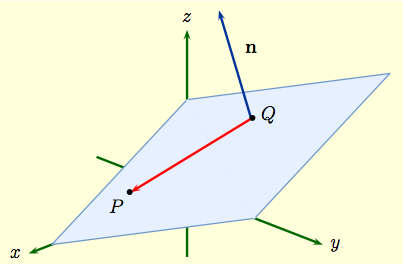

You can calculate the signed distance by $d_{s_{k}, n(s_{k})}(x) = (x - s_{k})^{T}n(s_{k})$ - project the vertical component of the difference.

Square can be calculated as $d_{s_{k},n(s_{k})}(x)^{2} = x^{T}A_{k}x - 2b_{k}^{T}x + c_{k}$ - here $A_{k} = n(s_{k})n(s_{k})^{T}, b_{k} = A_{k}s_{k}, c_{k} = s^{T}_{k}A_{k}s_{k}$. The relationship comes from simply expanding the dot product between vectors, and then using the commutativity of dot-product and associativity of matrix multiplication.

$QEM(x) = [x, 1]^t \underbrace{\begin{pmatrix}A & -b \\-b^t & c\end{pmatrix}}_{:= Q}[x, 1].$ - You can in the end calculate the sum of square vertical distances from point $x$ to the given set of planes defined by normals and points on a plane by a matrix multiplication. In other words, the sum of squared distances can be encoded by a $4x4$ real matrix.

## PoNQ Representation

Representation:

- Set $P = \{p_{i} \in \mathbb{R}^{3}\}$ - points
- Set $N = \{n_{i} \in \mathbb{R}^{3}\}$ - local normals of the corresponding points
- Set $Q = \{Q_{i} \in \mathbb{R}^{4 \times 4}\}$ - Set of quadratics

### Optimization

**Goal:** Fit a watertight and non-self-intersecting input shape. Finely discretized by samples $s_{k} \in S$ with local normals $n(s_{k})$.


Initialize points $P$ on a regular grid **around the input shape**. Optimize their position to minimize the bi-directional Chamfer Distance: $CP(P,S) = \frac{1}{|P|}\Sigma_{p_{i} \in P} min_{s_{k} \in S}||p_{i} - s_{k}||^{2} + \frac{1}{|S|}\Sigma_{s_{k} \in S}min_{p_{i} \in P}||p_{i}-s_{k}||^{2}$

**Explanation of the distance** CD takes in a set of points around the shape, and the points $S$ on the surface of the mesh. 

- The first term $\frac{1}{|P|}\Sigma_{p_{i} \in P} min_{s_{k} \in S}||p_{i} - s_{k}||^{2}$ minimizes the average minimum distances between points $s_{k}$ and $p_{i}$. So for all points $p_{i}$ it finds the closest point in the set $S$, squares the distance and adds to the sum.
- The second term does the same, but from the perspective of $P$. For all points $s_{k} \in S$ it finds the closest point in the set $P$, squares the distance and adds to the sum.

Essentially it optimizes the closest distance to the surface from both perspectives - resulting loss will enforce the points to lie close to and spread over the target surface.

**Note** Here keep in mind that we are optimizing over the points $P$ and the set $S$ is fixed by the dataset.

The points define a partition of $\mathbb{R}^{3}$ into Voronoi cells $V(p_{i})$, for which any location $x \in V(p_{i})$ has $p_{i}$ as it's closest point from $P$.

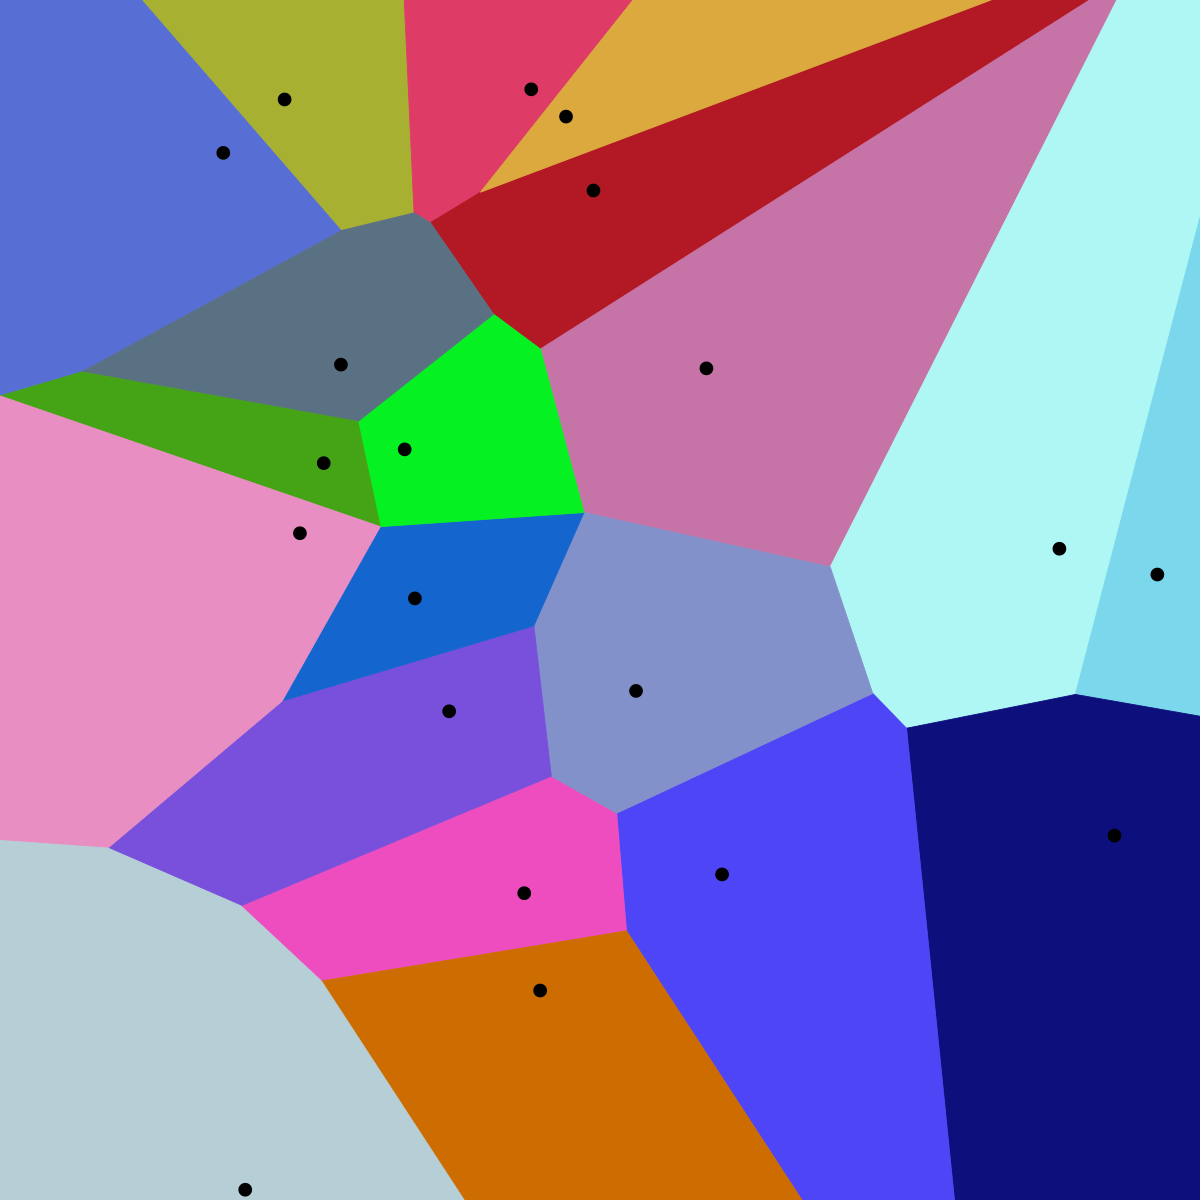

**AFTER** this optimization is done (Q: After iteration or after optimization in general?). Each point $p_{i} \in P$ is enriched with a normal $n_{i}$ and $QEM$ matrix $Q_{i}$. Where $n_{i}$ represents the average of $n(s_{k})$ (Sample normals) contained within $V(p_{i})$. $n_{i} = \frac{1}{|S \cap V(p_{i})|} \Sigma_{s_{k} \in S \cap V(p_{i})}n(s_{k})$.

**Note** Here we are optimizing for $n_{i}$, since in general we can have many normals.

Here, given the 3 vertex vectors of the mesh $v_{0}, v_{1}, v_{2}$, we can compute the (unnormalized) normal vector as $n_{f} = (v_{1} - v_{0}) \times (v_{2} - v_{0})$ - we take 2 vectors that are on the surface on the mesh and get an orthogonal vector to it. Generally we don't need normals in the dataset, but we can estimate it.

Then $Q_{i}$'s are assembled using the equations from the previous section, point normals and points on the planes $(n_{i}, n_{i}(s_{k}))'s$.

$[x,1]^{T}Q_{i}[x,1] = \Sigma_{s_{k} \in S \cap V(p_{i})} d^{2}_{s_{k},n(s_{k})}(x)$ - The sum of squared distances from x to the points on the plane define by points and normals of that points from the $V_{i}$ Voronoi cell.

**Idea** These additional properties give information about the geometry around each point $p_{i}$.

**Fact** The QEM function reaches its unique minimum at $v^{*} = A^{-1}b$.

### Learning with PoNQ

In this section they will apply it to the mesh reconstruction from the SDF (Signed Distance Field).

They use an arbitrary number $P$ of predicted points per cell of the Signed Distance Field. Here they user $P = 4$.

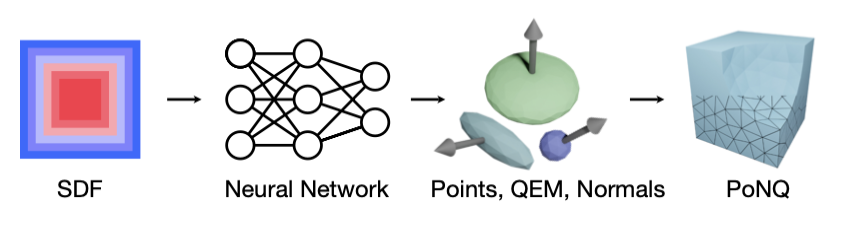

**Architecture:** 

1. Shared 5-layer encoder. Takes $(N+1)^{3}$ input SDF into $N^{3}$-sized grid of $128$ features
2. Features are processed by five zeparate 6-layer decoders (don't share weights), gives PoNQ as output $P \times N^{3}$ points $p_{i}$, associated $n_{i}$ normals and QEM matrices $Q_{i}$.
3. They add $o_{i} \in O$ of $N^{3}$ binary occupanices mark the voxels containing the surface at inference time

They use $-A_{i}v^{*}_{i}$ instead of $b$ to avoid the matrix inversion. 

Instead of $A$ they store $U$ which is a $3 \times 3$ upper-triangular matrix such that $A = U_{i}U_{i}^{T}$ is reversed Cholesky decomposition - this gurantees that $A$ is invertible.

**Important** Training is supervised by a collection of watertight shapes, each converted into a dense sampling $S$.

**Preprocess**: Compute the ground-truth occupancy $O_{gt}$ of $m$ containing samples to which we restrict loss terms.

### Losses and explanations

- $L_{CD}=CD(P,S)$ - Spread the pointset P and fit the inputs
- $L_{n}=\frac{1}{m} \Sigma_{i=1}^{m}\Sigma_{s_{k} \in S \cap V(p_{i})} ||n_{i} - n(s_{k})||^{2}$ - Enforce each normal is the mean normal of the local sample normals
- $L_{A} = \frac{1}{m} \Sigma_{i=1}^{m} \Sigma_{s_{k} \in S \cap V(p_{i})}||U_{i}U_{i}^{T} - n(s_{k})n(s_{k})^{T}||^{2}$ - Enforces that quadratic forms correspond to the proper submatrix of the QEM local samples
- $L_{v^{*}} = \frac{1}{m} \Sigma_{i=1}^{m}\Sigma_{s_{k} \in S \cap V(p_{i})} (n(s_{k})^{T}(v^{*}_{i} - s_{k}))^{2}$ - Enforce that $v^{*}_{i}$ minimizes the sum of squared distance to local tangent planes around $p_{i}$
- For fixed $p_{i}$ $L_{reg} = \frac{1}{m} \Sigma_{i=1}^{m} ||v^{*}_{i} - p_{i}||^{2}$ - Regularize the v_{i} to be close to p_{i}
- $L_{occ} = ||\mathbb{O} - O_{gt}||^{2}$ - Make sure that ground-truth occupancy set matches the model one.

### Representation Meshing

**Idea:** Uses vertices $v^{*}_{i}$ at QEM-optimal positions $v^{*}_{i}$.



## Loading the dataset

I will perform the experiment with the Thingi10k dataset

In [9]:
import stl_reader
import torch

vertices, indices = stl_reader.read("./Thingi10k/raw_meshes/1722414.stl")